In [ ]:
pip install --upgrade ipykernel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import random
from os.path import isfile
import numpy as np
import gym
from abc import ABC, abstractmethod
from collections import defaultdict, namedtuple, deque
import matplotlib.pyplot as plt
from keras import Sequential, Input
from keras.activations import relu, linear
from keras.layers import Dense, Dropout
from keras.losses import mse, huber_loss
import tensorflow as tf
from keras.optimizers import Adam
from scipy.stats import norm
import math
import json
import seaborn as sns
import pandas as pd
from itertools import count
import torch
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

2023-04-09 03:23:27.727820: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1. Environment

In [2]:
class EnvCartPole:
    def __init__(self, discretize=False, discrete_base=None, new_step_api=True):
        self.new_step_api = new_step_api
        if new_step_api:
            self._env = gym.make("CartPole-v1", new_step_api=new_step_api)
        else:
            self._env = gym.make("CartPole-v1")
        self.n_actions = self._env.action_space.n
        self.n_observation_space = self._env.observation_space.shape[0]
        self.base = discrete_base
        self.discretize = discretize
        pass

    def sample_action(self):
        return self._env.action_space.sample()

    @staticmethod
    def norm_spacing(x, lim, base):
        """
        see example of discretizing:
        for x in np.arange(-lim, lim, 0.1):
            print("x=%.1f, bin id: %d" % (x, math.ceil(norm.cdf(x / lim * 3) * base) - 1))
        """
        assert (abs(x) <= lim)
        if math.isinf(lim):
            b = math.ceil(norm.cdf(x) * base) - 1
        else:
            b = math.ceil(norm.cdf(x / lim * 3) * base) - 1
        return b if b >= 0 else 0

    def state_discretize(self, s):
        """
        See definition of observation-space:
        https://www.gymlibrary.dev/environments/classic_control/cart_pole/#observation-space
        """
        [Cart_Position, Cart_Velocity, Pole_Angle, Pole_Angular_Velocity] = s
        bins = np.array([
            self.norm_spacing(Cart_Position, 4.8, self.base) * math.pow(self.base, 3),
            self.norm_spacing(Cart_Velocity, np.inf, self.base) * math.pow(self.base, 2),
            self.norm_spacing(Pole_Angle, 0.418, self.base) * math.pow(self.base, 1),
            self.norm_spacing(Pole_Angular_Velocity, np.inf, self.base) * math.pow(self.base, 0),
        ], dtype=int)
        # print("current bin id: ", bins.sum())
        return str(bins.sum())

    def reset(self):
        s = self._env.reset()
        if self.discretize:
            return self.state_discretize(s)
        else:
            if isinstance(s[1], dict) and isinstance(s[0], np.ndarray):
                return np.array([s[0]])
            else:
                return np.array([s])

    def step(self, a, new_reward=False):
        """
        SEE API definition: https://github.com/openai/gym/blob/master/gym/core.py
        """
        if self.new_step_api:
            s_, r, terminated, truncated = self._env.step(a)[:4]
        else:
            s_, r, terminated = self._env.step(a)[:3]
            truncated = False

        if self.discretize:
            s_ = self.state_discretize(s_)  # Applying discretization to s'
        else:
            s_ = np.array([s_])  # or 

        if new_reward:  # instead of the default setting, only a punishment will return when failed, otherwise 0.
            r = -1 if terminated else 0

        return s_, r, terminated, truncated


## 1.1. Let's have a look at the states of environment

### 1.1.1. State in a 2-D array as default

In [3]:
env = EnvCartPole(new_step_api=True, discretize=False)
for i in range(10):
    print(env.reset())  # generating a contious state as a 2-D array

[[0.00568283 0.04427578 0.0038558  0.03942027]]
[[ 0.0248539  -0.0005371   0.02523008 -0.01653448]]
[[-0.0122786   0.02840434 -0.00181291 -0.01469856]]
[[ 0.04707563 -0.01799884 -0.0003169  -0.00170915]]
[[-0.00401203  0.00871859 -0.02288651 -0.02112564]]
[[-0.04804464 -0.03758281 -0.01859241 -0.04134453]]
[[0.00012766 0.00118646 0.03224208 0.02911781]]
[[ 0.04045567  0.0027198   0.04897704 -0.03004796]]
[[ 0.04180244 -0.0366092   0.03809243  0.02065346]]
[[0.00464131 0.04927104 0.03364421 0.00571359]]


### 1.1.2. Stete in scalar

In [4]:
env = EnvCartPole(new_step_api=True, discretize=True, discrete_base=10)
for i in range(10):
    print(env.reset())  # a discretized state as a scalar

4535
4535
5434
5554
4465
5555
5545
5435
4565
5465


## 1.2. Mapping and discritizing of a contious state

States in the center of its range are with higher probability. Here is the visualization of how `norm_spacing()` works for an individual state observation.

x=-4.8, bin id: 0
x=-2.1, bin id: 1
x=-1.3, bin id: 2
x=-0.8, bin id: 3
x=-0.4, bin id: 4
x=0.0, bin id: 5
x=0.4, bin id: 6
x=0.8, bin id: 7
x=1.3, bin id: 8
x=2.1, bin id: 9
x=4.8, bin id: 9


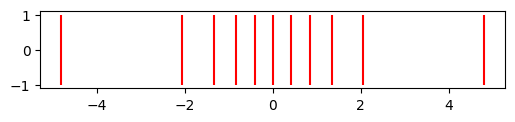

In [5]:
base = 10
bound, bin = 4.8, -1
lst = []
for x in np.arange(-bound, bound, 0.01):
    new_bin = math.ceil(norm.cdf(x / bound * 3) * base) - 1
    if new_bin > bin:
        lst.append(x)
        bin = new_bin
        print("x=%.1f, bin id: %d" % (x, new_bin))
print("x=%.1f, bin id: %d" % (bound, bin))
lst.append(bound)
plt.figure(figsize=(6, 1))
plt.vlines(lst, -1, 1, color="red")

## 1.3. Returns of `env.action()`

In [6]:
from itertools import count
env = gym.make("CartPole-v1", new_step_api=True)  # debugging new step API
env.reset()
s = set()
for i in range(1000):
    observation, reward, terminated, truncated, _ = env.step(0)
    s.add((terminated, truncated))
print(i)
print(s)  # truncated can be used to end the episode prematurely before a `terminal state` is reached.

999
{(True, False), (True, True), (False, False)}


/usr/local/lib/python3.9/dist-packages/gym/envs/classic_control/cartpole.py:179: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


# 2. Agent

A defination of an agent contains some params to record its runtime and some behaviors to act.

In [3]:
class Agent:
    def __init__(self, environment, n_episodes=1, n_steps=1, gamma=0.5, alpha=0.5,
                 epsilon=None, epsilon_start=0.95, epsilon_end=0.05, epsilon_decay=1.0e+05, checkpoint_name=None):
        self.env = environment
        self.n_actions = self.env.n_actions
        self.n_obs_space = self.env.n_observation_space
        self.dynamic_e_greedy = True if epsilon is None else False
        self.epsilon = epsilon  # static e-greedy hyperparameter, default None
        self.epsilon_start = epsilon_start  # dynamic e-greedy params
        self.epsilon_end = epsilon_end  # dynamic e-greedy params
        self.epsilon_decay = epsilon_decay  # dynamic e-greedy params
        self.g = gamma
        self.lr = alpha
        self.n_episodes = n_episodes
        self.n_steps = n_steps
        self.Q = defaultdict(lambda: [0] * self.n_actions)
        self.steps = []
        self.sum_steps = 0
        self.avg_steps = []
        self.checkpoint_name = checkpoint_name
        self.policy_net, self.target_net = None, None
        pass

    @abstractmethod
    def learning(self, s, a, r, s_, d):  # learning from sars_
        pass

    @abstractmethod
    def action(self, s):
        pass

    def random_action(self):
        return random.randint(0, self.n_actions)

    def keep_running(self, new_r=False):
        self.read_policy()  # read checkpoint
        self.run(new_r=new_r)

    @abstractmethod
    def run(self, new_r=False):
        pass

    @abstractmethod
    def test(self, new_r=False):
        pass

    def save_policy(self):
        checkpoint = {"Q": self.Q, "steps": self.steps, "avg_steps": self.avg_steps,
                      "epsilon": self.epsilon, "dynamic_epsilon": self.dynamic_e_greedy}
        open('./' + self.checkpoint_name + '.json', 'w').write(json.dumps(checkpoint))
        # print("save runtime environments")
        if self.policy_net is not None:
            self.policy_net.save("%s/%s/" % (self.checkpoint_name, self.policy_net._name))
            # print("save policy_net")
        if self.target_net is not None:
            self.target_net.save("%s/%s/" % (self.checkpoint_name, self.target_net._name))
            # print("save target_net")
        pass

    def read_policy(self):
        try:
            checkpoint = json.loads(open('./' + self.checkpoint_name + '.json', 'r').read())
            self.Q = defaultdict(lambda: [0] * self.n_actions, checkpoint["Q"])
            self.steps = checkpoint["steps"]
            self.sum_steps = np.array(self.steps).sum()
            self.avg_steps = checkpoint["avg_steps"]
            if self.dynamic_e_greedy and checkpoint["dynamic_epsilon"]:
                self.dynamic_e_greedy = checkpoint["dynamic_epsilon"]
                self.epsilon = checkpoint["epsilon"]
            print('read checkpoint from ./' + self.checkpoint_name + '.json')
            if self.policy_net is not None:
                path = "%s/%s/" % (self.checkpoint_name, self.policy_net._name)
                if isfile(path):
                    self.policy_net.load_weights(path)  # load policy_net
                    print("load weights to policy_net")
            if self.target_net is not None:
                path = "%s/%s/" % (self.checkpoint_name, self.target_net._name)
                if isfile(path):
                    self.target_net.load_weights(path)  # load target_net
                    print("load weights to target_net")
            print("Epsilon starts from %.4f" % (self.epsilon_start if self.epsilon is None else self.epsilon))
        except Exception as e:
            print("skip from reading checkpoint: ", self.checkpoint_name)
            print(e)
            pass

    def cumsum_plot(self, random_step, smart_steps, last_n_steps=0):
        f = pd.DataFrame({"Random Agent": np.cumsum(random_step)[last_n_steps:],
                          "Smart Agent": np.cumsum(smart_steps)[last_n_steps:],
                          })
        f = self.dataframe_stack(f)
        self.vis(f, title='Accumulation Steps', x_label='Episodes', y_label='Steps', save_file='./cum_steps.jpg')
    
    def rolling_plot(self, last_n_steps=0):
        f = pd.DataFrame({"Steps": self.steps[last_n_steps:]})
        f['MA_100'] = f['Steps'].rolling(100).mean()
        f = self.dataframe_stack(f)
        self.vis(f, title='Rolling Steps', x_label='Episodes', y_label='Steps', save_file='./rolling_steps.jpg')

    @staticmethod
    def dataframe_stack(f):
        f.fillna(0.0)
        f = f.stack().reset_index()
        f.columns = ["x", "hue", "y"]
        return f

    @staticmethod
    def vis(data, title, x_label, y_label, save_file):
        fig, ax = plt.subplots(1, 1, figsize=(10, 3), dpi=100)
        sns.lineplot(data=data, x="x", y="y", hue="hue", markers=False, dashes=False, lw=1, ax=ax)

        ax.set_title(title)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_yscale('log')
        ax.grid(color='black', linestyle='--', which='major', linewidth=0.5)
        ax.grid(color='gray', linestyle='--', which='minor', linewidth=0.3)

        ax.legend()
        plt.tight_layout()
        plt.savefig(save_file)
        plt.show()



# 3. Q-learning Agent Implementation

The expected optimal policy $E[Q(s,a)]$ can be defined as $max_a[Q(s',A)]$ as shown in equation 4.9.

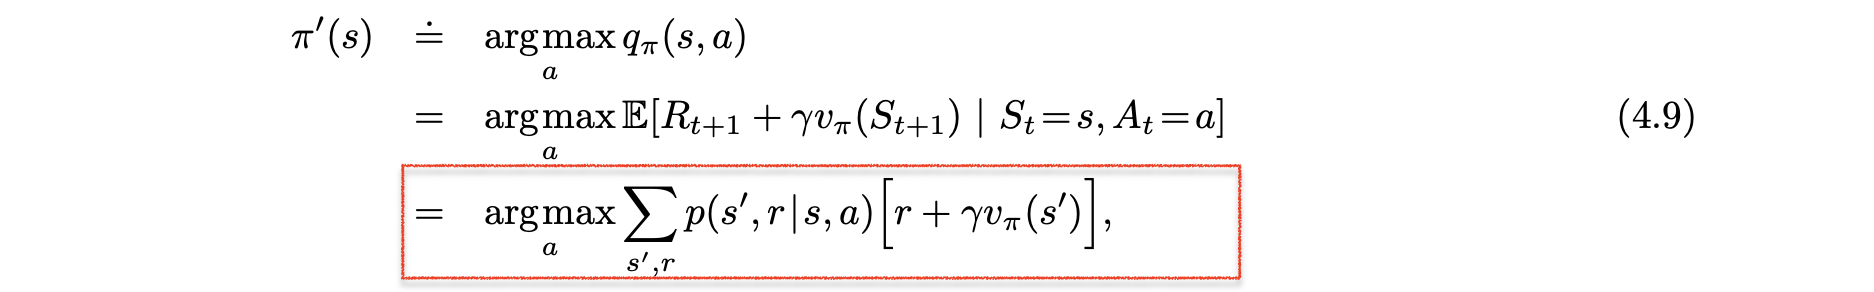

Thus we can defines an optimizating process by reducing the error between `Expectation` and `Observations` by **TD-Control** in equation 6.2: the smaller the diff is the better the policy will be.

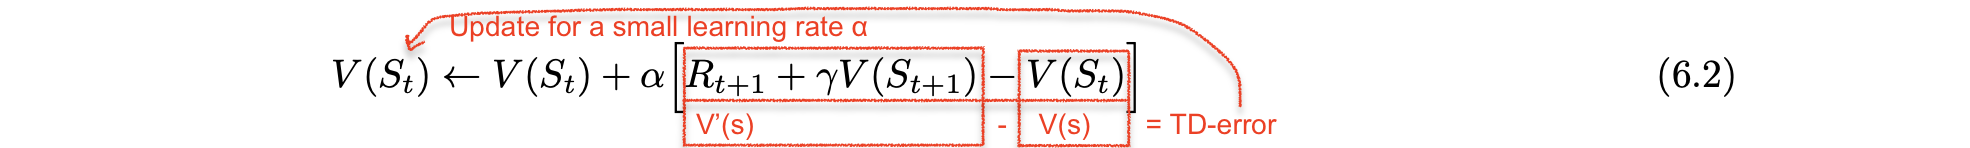

A backup diagram is helpful to better understand this optimazation process.

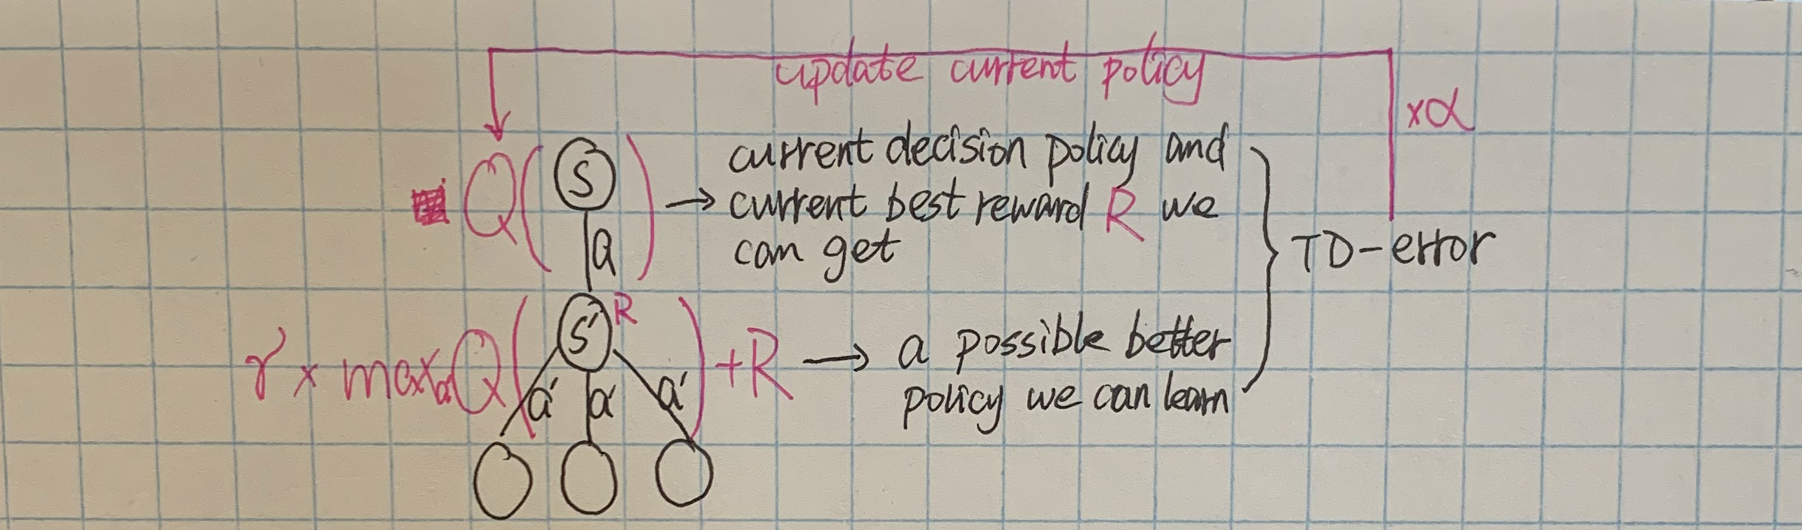

In order to complete this optimization process, we need a table to store every possible action in every possible state. This is called a Q-table: which is going to be used as `the Policy Q`.

A Q-table helps us to find the best action for each state in the environment. We use the `Bellman Equation` at each state to get the expected future state and reward and save it in a table to compare with other states.

Here is the Q-learning algorithm.

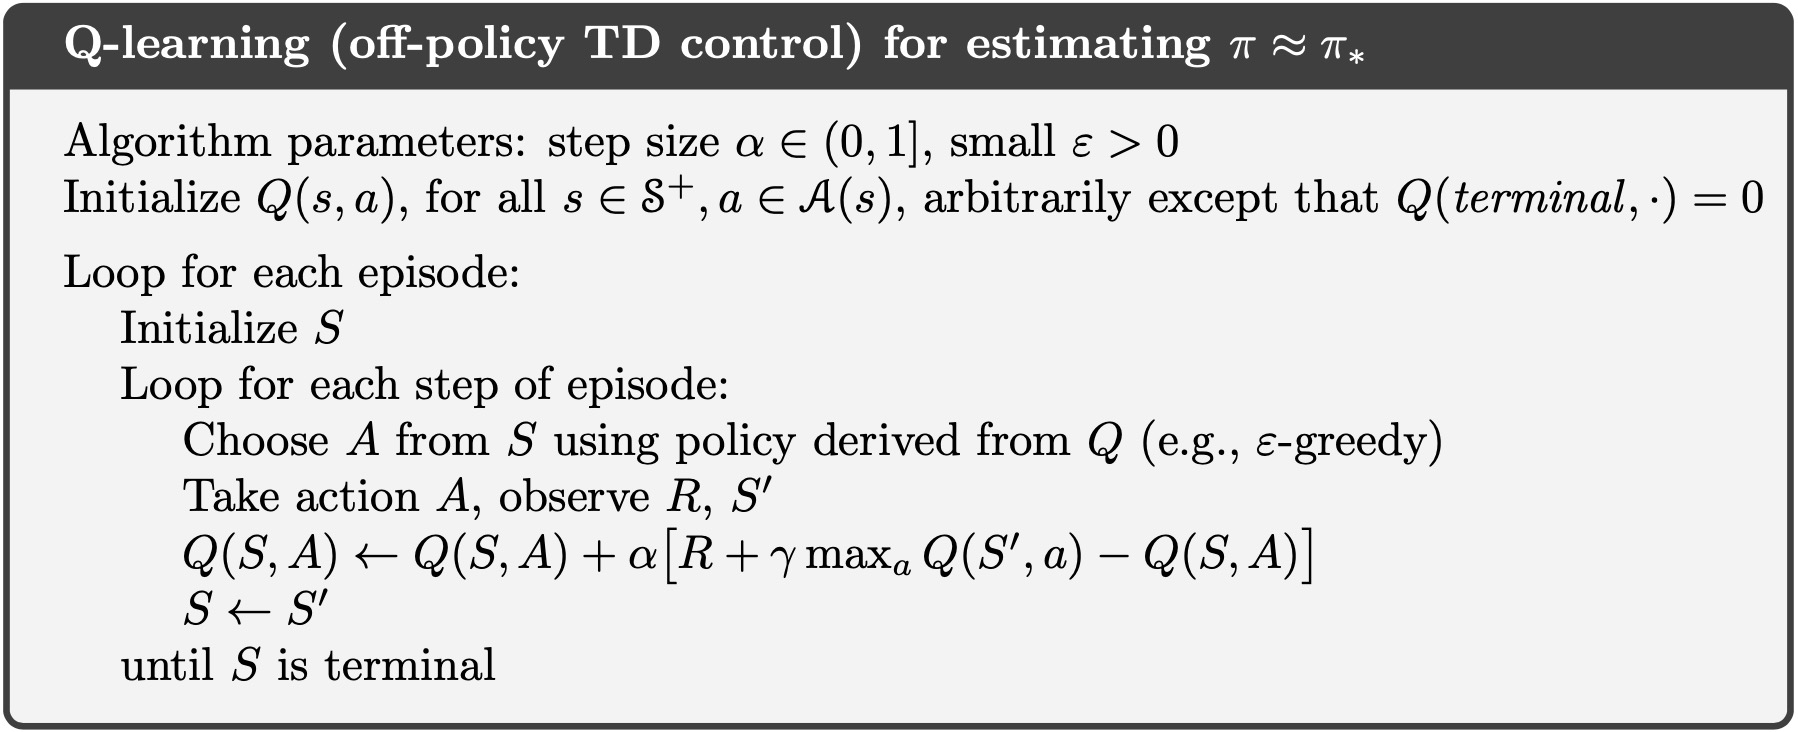

## 3.1. Q-learning Algorithm Implementation

In [8]:
class QAgent(Agent, ABC):
    def __init__(self, environment, n_episodes=1, n_steps=1, gamma=0.5, alpha=0.5,
                 epsilon=None, epsilon_start=0.95, epsilon_end=0.05, epsilon_decay=1.0e+05,
                 checkpoint_name="policy3", ):
        super().__init__(environment, n_episodes, n_steps, gamma, alpha,
                         epsilon, epsilon_start, epsilon_end, epsilon_decay, checkpoint_name)
        self.env.discretize = True  # set the env act as discretized
        pass

    def action(self, state):  # ------------------------------------------------ epsilon-greedy action policy
        if self.dynamic_e_greedy:  # ------------------------------------------- dynamic e-greedy
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(-1. * self.sum_steps / self.epsilon_decay)
        self.sum_steps += 1  # update e-greedy after each step
        if np.random.uniform(low=0.0, high=1.0) < self.epsilon:  # ------------- epsilon exploration
            return self.env.sample_action()
        else:  # --------------------------------------------------------------- or greedy exploitation
            return np.argmax(self.Q[state][:])  # unique for q-learning

    def learning(self, s, a, r, s_, d):  # update q-table with bellman equation
        self.Q[s][a] += self.lr * (r + self.g * max(self.Q[s_][:]) - self.Q[s][a])

    def run(self, new_r=False):
        for episode in range(1, self.n_episodes + 1):  # -----------------------  Loop for each episode
            s = self.env.reset()  # --------------------------------------------     Initialize S
            for step in range(1, self.n_steps + 1):  # -------------------------     Loop for each step of episode
                a = self.action(s)  # ------------------------------------------        Choose A from S using policy derived from Q (e.g., ε-greedy)
                s_, r, done, trunc = self.env.step(a, new_reward=new_r)  # -----        Take action A, observe R, S'
                self.learning(s, a, r, s_, done)  # ----------------------------        Q(S, A) = Q(S, A) + α[R + γ max Q(S', a) - Q(S, A)]
                s = s_  # ------------------------------------------------------        S = S'
                if done:  # ----------------------------------------------------     until S is terminal
                    self.steps.append(step)
                    self.avg_steps.append(np.mean(self.steps[-10:]))
                    if episode % 50 == 0:
                        print("[%d/%d]: %d, %.4f" % (episode, self.n_episodes, step + 1, self.epsilon))
                    if episode % 100 == 0:
                        self.save_policy()
                    break
        print("Epsilon ends at %.4f" % (self.epsilon_start if self.epsilon is None else self.epsilon))
        pass

    def test(self, new_r=False):
        self.read_policy()  # read policy from checkpoint
        self.steps = []
        for episode in range(1, self.n_episodes + 1):  # Loop for each episode
            s = self.env.reset()  # Initialize S
            for step in count():
                a = self.action(s)
                s, _, done, trunc = self.env.step(a, new_reward=new_r)  # directly use s=s_
                if done or trunc:  # until S is terminal
                    self.steps.append(step + 1)
                    break
        return self.steps


## 3.2. Training a Q-learning agent with a fixed e-greedy policy = 1 with 3000 episodes

e=1 means this is a total random walking agent

[50/3000]: 35, 1.0000
[100/3000]: 13, 1.0000
[150/3000]: 19, 1.0000
[200/3000]: 22, 1.0000
[250/3000]: 44, 1.0000
[300/3000]: 22, 1.0000
[350/3000]: 18, 1.0000
[400/3000]: 18, 1.0000
[450/3000]: 16, 1.0000
[500/3000]: 37, 1.0000
[550/3000]: 21, 1.0000
[600/3000]: 16, 1.0000
[650/3000]: 11, 1.0000
[700/3000]: 35, 1.0000
[750/3000]: 19, 1.0000
[800/3000]: 14, 1.0000
[850/3000]: 11, 1.0000
[900/3000]: 15, 1.0000
[950/3000]: 19, 1.0000
[1000/3000]: 13, 1.0000
[1050/3000]: 13, 1.0000
[1100/3000]: 24, 1.0000
[1150/3000]: 17, 1.0000
[1200/3000]: 44, 1.0000
[1250/3000]: 14, 1.0000
[1300/3000]: 19, 1.0000
[1350/3000]: 17, 1.0000
[1400/3000]: 18, 1.0000
[1450/3000]: 24, 1.0000
[1500/3000]: 14, 1.0000
[1550/3000]: 16, 1.0000
[1600/3000]: 25, 1.0000
[1650/3000]: 31, 1.0000
[1700/3000]: 13, 1.0000
[1750/3000]: 24, 1.0000
[1800/3000]: 21, 1.0000
[1850/3000]: 12, 1.0000
[1900/3000]: 39, 1.0000
[1950/3000]: 26, 1.0000
[2000/3000]: 12, 1.0000
[2050/3000]: 20, 1.0000
[2100/3000]: 11, 1.0000
[2150/3000]:

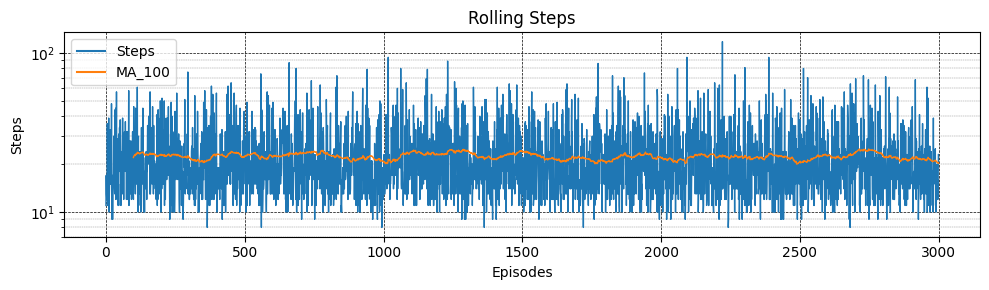

In [9]:
env = EnvCartPole(discrete_base=8, new_step_api=True)
agent1 = QAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, alpha=0.5, epsilon=1, 
                checkpoint_name="policy1", )
agent1.run(new_r=False)
agent1.rolling_plot()

## 3.3. Training a Q-learning agent with a dynamic e-greedy policy with 3000 episodes

Epsilon starts from 0.9500
[50/3000]: 26, 0.9270
[100/3000]: 16, 0.9057
[150/3000]: 14, 0.8816
[200/3000]: 12, 0.8615
[250/3000]: 24, 0.8431
[300/3000]: 23, 0.8238
[350/3000]: 28, 0.8030
[400/3000]: 14, 0.7831
[450/3000]: 23, 0.7631
[500/3000]: 50, 0.7415
[550/3000]: 28, 0.7208
[600/3000]: 15, 0.7038
[650/3000]: 23, 0.6865
[700/3000]: 18, 0.6617
[750/3000]: 25, 0.6374
[800/3000]: 28, 0.6187
[850/3000]: 45, 0.5971
[900/3000]: 47, 0.5776
[950/3000]: 24, 0.5552
[1000/3000]: 36, 0.5351
[1050/3000]: 48, 0.5136
[1100/3000]: 39, 0.4936
[1150/3000]: 23, 0.4665
[1200/3000]: 106, 0.4383
[1250/3000]: 75, 0.4141
[1300/3000]: 47, 0.3853
[1350/3000]: 142, 0.3618
[1400/3000]: 30, 0.3310
[1450/3000]: 123, 0.3014
[1500/3000]: 251, 0.2725
[1550/3000]: 117, 0.2450
[1600/3000]: 165, 0.2176
[1650/3000]: 193, 0.1906
[1700/3000]: 122, 0.1689
[1750/3000]: 132, 0.1435
[1800/3000]: 263, 0.1227
[1850/3000]: 191, 0.1031
[1900/3000]: 58, 0.0847
[1950/3000]: 120, 0.0733
[2000/3000]: 111, 0.0595
[2050/3000]: 259, 0.

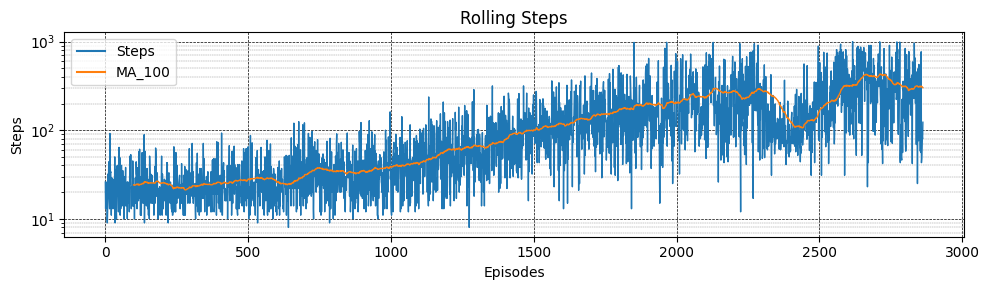

In [ ]:
env = EnvCartPole(discrete_base=10, new_step_api=True)
agent2 = QAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, alpha=0.3, epsilon=None,
                epsilon_start=0.95, epsilon_end=0.01, epsilon_decay=5.0e+04, 
                checkpoint_name="policy2", )
agent2.run(new_r=False)
agent2.rolling_plot()

## 3.4. Q-Learning Agent Comparison

Set epsilon to 0 to apply trained Q-Table policy.

read checkpoint from ./policy1.json
Epsilon starts from 1.0000
read checkpoint from ./policy2.json
Epsilon starts from 0.0102


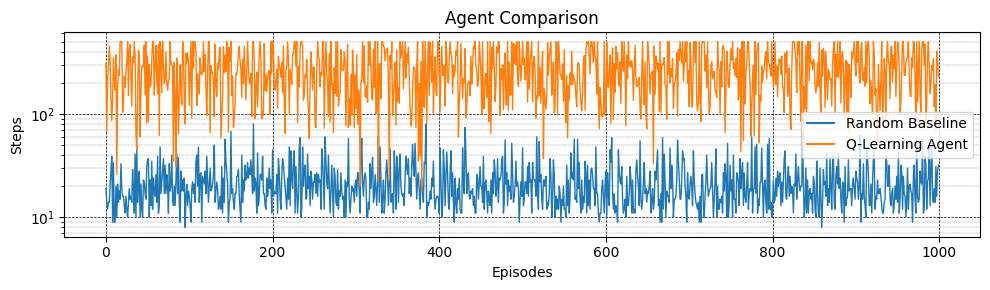

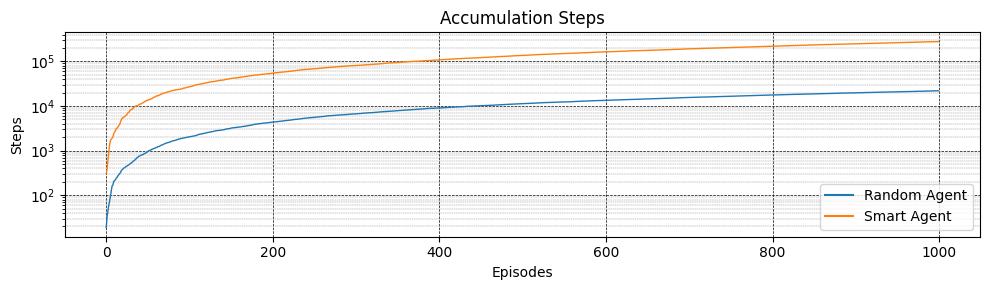

In [ ]:
# define e=0 to apply policy 1, which is a random baseline
agent1 = QAgent(env, n_episodes=1000, epsilon=0, checkpoint_name="policy1", )
test1 = agent1.test(new_r=False)

# define e=0 to apply policy 2, which is a Q-Learning Agent
agent2 = QAgent(env, n_episodes=1000, epsilon=0, checkpoint_name="policy2", )
test2 = agent2.test(new_r=False)

df = pd.DataFrame({"Random Baseline": test1[-1000:], "Q-Learning Agent": test2[-1000:]})
df = df.stack().reset_index()
df.columns = ["x", "hue", "y"]

agent2.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison")
agent2.cumsum_plot(test1, test2)


# 4. DQN Agent Implementation

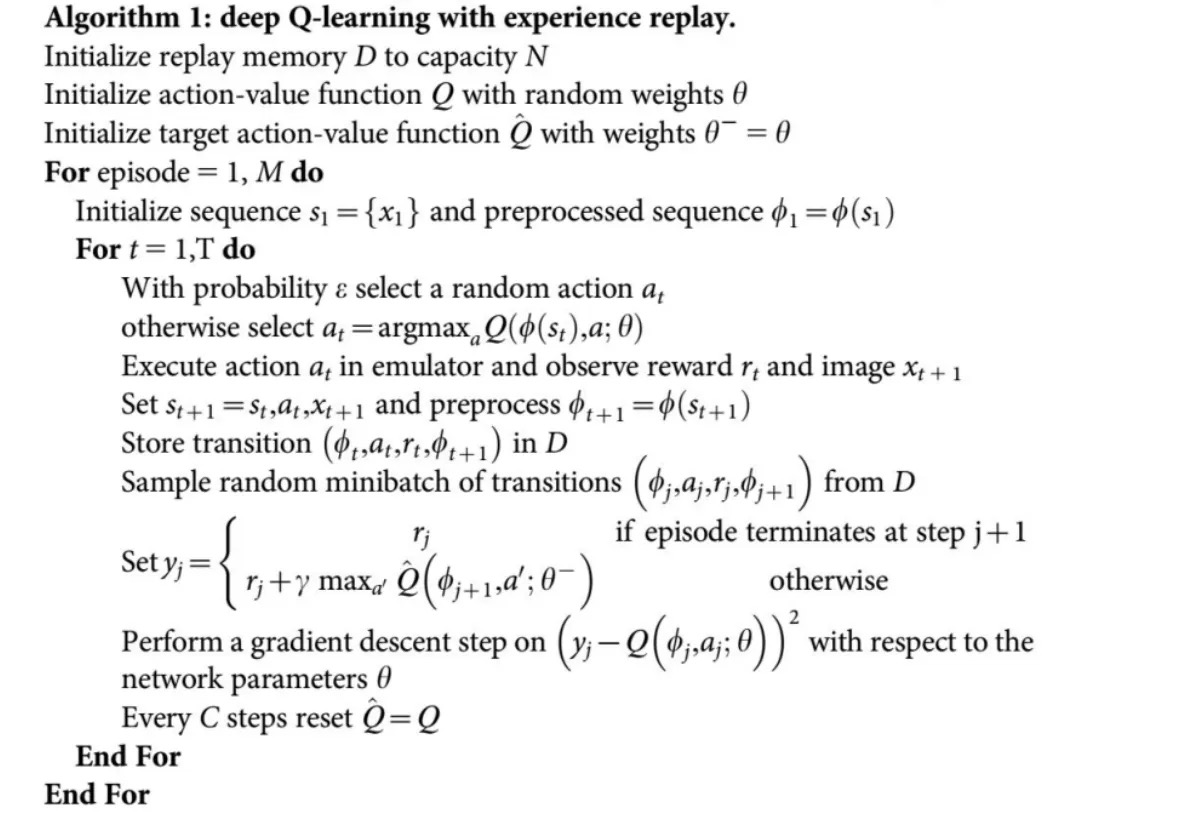

## 4.1. DQN Algorithm Implementation

In [15]:
class DQNAgent(Agent, ABC):
    def __init__(self, environment, n_episodes=1, n_steps=1, gamma=0.5,
                 memory_cap=10000, batch_size=64, alpha=1.0e-4, tau=1.,
                 epsilon=None, epsilon_start=0.95, epsilon_end=0.05, epsilon_decay=1.0e+05,
                 checkpoint_name=None, ):
        super().__init__(environment, n_episodes, n_steps, gamma, alpha,
                         epsilon, epsilon_start, epsilon_end, epsilon_decay, checkpoint_name)
        self.env.discretize = False  # DQN support a continues state space, then False
        self.experiences = self.ExperienceReplay(memory_cap, batch_size)
        # DNN
        self.optimizer = Adam(learning_rate=self.lr, amsgrad=True)
        self.policy_net = self.DNN("policy_net")
        self.target_net = self.DNN("target_net")
        self.TAU = tau  # for a soft update if less than 1

    def DNN(self, model_name):
        dnn = Sequential([
            Input(shape=(self.n_obs_space,)),
            Dense(128, activation="relu"),
            Dense(128, activation="relu"),
            Dense(self.n_actions, activation="linear")
        ])
        dnn.compile(loss=mse, optimizer=Adam(learning_rate=self.lr))
        dnn._name = model_name
        return dnn

    class ExperienceReplay(object):
        def __init__(self, capacity, batch_size):
            self.Transition = namedtuple('Transition', ('s', 'a', 'r', 's_', 'd'))
            self.batch_size = batch_size
            self.memory = deque([], maxlen=capacity)

        def push(self, *args):
            self.memory.append(self.Transition(*args))  # push a transition into memory

        def sample(self, n_actions):
            transitions = random.sample(self.memory, self.batch_size)  # transitions sampling
            batch = self.Transition(*zip(*transitions))
            s = tf.squeeze(tf.convert_to_tensor(batch.s, dtype=tf.float32), axis=1)
            a = tf.one_hot(batch.a, n_actions, dtype=tf.float32)
            r = tf.convert_to_tensor(batch.r, dtype=tf.float32)
            s_ = tf.squeeze(tf.convert_to_tensor(batch.s_, dtype=tf.float32), axis=1)
            d = np.ones(self.batch_size) - tf.convert_to_tensor(batch.d, dtype=tf.float32)
            return s, a, r, s_, d  # zip transitions into a batch

        def allow_sampling(self):
            return self.__len__() >= self.batch_size

        def __len__(self):
            return len(self.memory)

    def action(self, s):  # ------------------------------------------------ epsilon-greedy action policy
        if self.dynamic_e_greedy:  # ------------------------------------------- dynamic e-greedy
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * math.exp(
                -1. * self.sum_steps / self.epsilon_decay)
        self.sum_steps += 1  # update e-greedy after each step
        if np.random.uniform(low=0.0, high=1.0) < self.epsilon:  # ------------- epsilon exploration
            return self.env.sample_action()
        else:  # --------------------------------------------------------------- or greedy exploitation
            return np.argmax(self.policy_net(s))

    def keep_running(self, new_r=False):
        self.read_policy()  # read policy from checkpoint
        self.run(new_r=new_r)

    def plot_durations(self, show_result=False):
        plt.figure(1, figsize=(10, 3), dpi=100)
        durations_t = torch.tensor(self.steps, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())
        # Take 100 episode averages and plot them too
        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)  # pause a bit so that plots are updated
        if is_ipython:
            if not show_result:
                display.display(plt.gcf())
                display.clear_output(wait=True)
            else:
                display.display(plt.gcf())

    @tf.function
    def _learning(self, s, a, r, s_, mask):
        with tf.GradientTape() as g:
            real_q = tf.reduce_sum(self.policy_net(s) * a, axis=1)  # q_values_taken_by_action
            max_q_ = tf.reduce_max(self.target_net(s_), axis=1)
            loss = mse(r + mask * self.g * max_q_, real_q)  # mse loss
        gradients = g.gradient(loss, self.policy_net.trainable_variables)  # compute gradients with loss
        self.optimizer.apply_gradients(zip(gradients, self.policy_net.trainable_variables))  # Backpropagation

    def learning(self, s, a, r, s_, d):
        self.experiences.push(s, a, r, s_, d)
        if not self.experiences.allow_sampling():
            return

        s, a, r, s_, d = self.experiences.sample(self.n_actions)
        self._learning(s, a, r, s_, d)  # sampling from replay memory

        # Soft update: θ′ ← τ θ + (1 −τ )θ′
        new_weights = []
        w1 = self.policy_net.weights
        w2 = self.target_net.weights
        for i in range(len(self.policy_net.weights)):
            new_weights.append(w1[i] * self.TAU + w2[i] * (1 - self.TAU))
        self.target_net.set_weights(new_weights)
        # or update target network every N steps:
        # if self.sum_steps % N == 0:
        #     from keras.models import clone_model
        #     self.target_net = clone_model(self.policy_net)
        pass

    def run(self, new_r=False):
        for episode in range(1, self.n_episodes + 1):
            s = self.env.reset()
            for step in range(1, self.n_steps + 1):
                a = self.action(s)
                s_, r, done, trunc = self.env.step(a, new_reward=new_r)
                self.learning(s, a, r, s_, done)
                s = s_
                if done:
                    self.steps.append(step)
                    self.avg_steps.append(np.mean(self.steps[-10:]))
                    if episode % 20 == 0:
                        # self.plot_durations()
                        print("[%d/%d]: steps %d, epsilon %.4f" % (episode, self.n_episodes, step, self.epsilon))
                    if episode % 200 == 0:
                        self.save_policy()
                    break
        print("Epsilon ends at %.4f" % (self.epsilon_start if self.epsilon is None else self.epsilon))
        pass

    def test(self, new_r=False):
        self.read_policy()  # read policy from checkpoint
        self.steps = []
        for episode in range(1, self.n_episodes + 1):  # Loop for each episode
            s = self.env.reset()  # Initialize S
            for step in count():
                a = self.action(s)
                selv.env._env.render()
                s, _, done, trunc = self.env.step(a, new_reward=new_r)  # directly use s=s_
                if done or trunc:  # until S is terminal
                    self.steps.append(step + 1)
                    break
        return self.steps

## 4.2. Training a DQN agent with a fixed e-greedy policy = 1

This is a random baseline

[20/3000]: steps 29, epsilon 1.0000
[40/3000]: steps 23, epsilon 1.0000
[60/3000]: steps 22, epsilon 1.0000
[80/3000]: steps 29, epsilon 1.0000
[100/3000]: steps 24, epsilon 1.0000
[120/3000]: steps 28, epsilon 1.0000
[140/3000]: steps 13, epsilon 1.0000
[160/3000]: steps 23, epsilon 1.0000
[180/3000]: steps 16, epsilon 1.0000
[200/3000]: steps 26, epsilon 1.0000
INFO:tensorflow:Assets written to: policy3/policy_net/assets
INFO:tensorflow:Assets written to: policy3/target_net/assets
[220/3000]: steps 20, epsilon 1.0000
[240/3000]: steps 21, epsilon 1.0000
[260/3000]: steps 14, epsilon 1.0000
[280/3000]: steps 24, epsilon 1.0000
[300/3000]: steps 27, epsilon 1.0000
[320/3000]: steps 40, epsilon 1.0000
[340/3000]: steps 21, epsilon 1.0000
[360/3000]: steps 10, epsilon 1.0000
[380/3000]: steps 14, epsilon 1.0000
[400/3000]: steps 31, epsilon 1.0000
INFO:tensorflow:Assets written to: policy3/policy_net/assets
INFO:tensorflow:Assets written to: policy3/target_net/assets
[420/3000]: steps 22

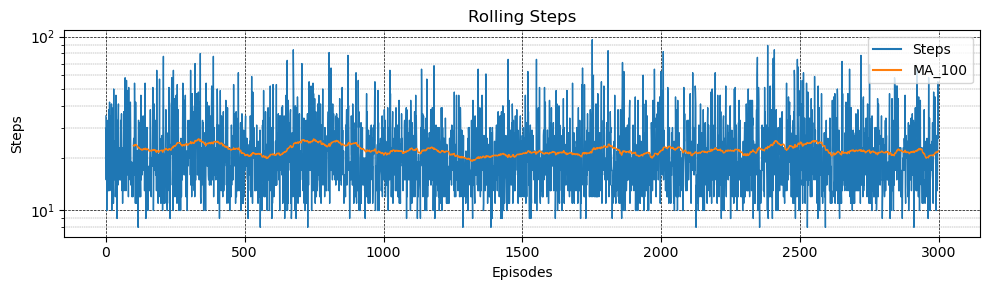

In [23]:
# train random baseline
env = EnvCartPole(new_step_api=False)
agent3 = DQNAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, epsilon=1, 
                  memory_cap=1000, batch_size=2, alpha=1.0e-4, tau=0.005, 
                  checkpoint_name="policy3", )
agent3.run(new_r=False)
agent3.rolling_plot()

## 4.3. Training a DQN Agent with a dynamic e-greedy policy

[20/3000]: steps 21, epsilon 0.9185
[40/3000]: steps 11, epsilon 0.8905
[60/3000]: steps 11, epsilon 0.8621
[80/3000]: steps 18, epsilon 0.8294
[100/3000]: steps 17, epsilon 0.7881
[120/3000]: steps 67, epsilon 0.7286
[140/3000]: steps 41, epsilon 0.6789
[160/3000]: steps 39, epsilon 0.6219
[180/3000]: steps 500, epsilon 0.4804
[200/3000]: steps 223, epsilon 0.3288
INFO:tensorflow:Assets written to: policy4/policy_net/assets
INFO:tensorflow:Assets written to: policy4/target_net/assets
[220/3000]: steps 213, epsilon 0.2085
[240/3000]: steps 267, epsilon 0.1192
[260/3000]: steps 143, epsilon 0.0800
[280/3000]: steps 178, epsilon 0.0617
[300/3000]: steps 231, epsilon 0.0397
[320/3000]: steps 500, epsilon 0.0227
[340/3000]: steps 205, epsilon 0.0123
[360/3000]: steps 11, epsilon 0.0114
[380/3000]: steps 9, epsilon 0.0113
[400/3000]: steps 9, epsilon 0.0112
INFO:tensorflow:Assets written to: policy4/policy_net/assets
INFO:tensorflow:Assets written to: policy4/target_net/assets
[420/3000]: s

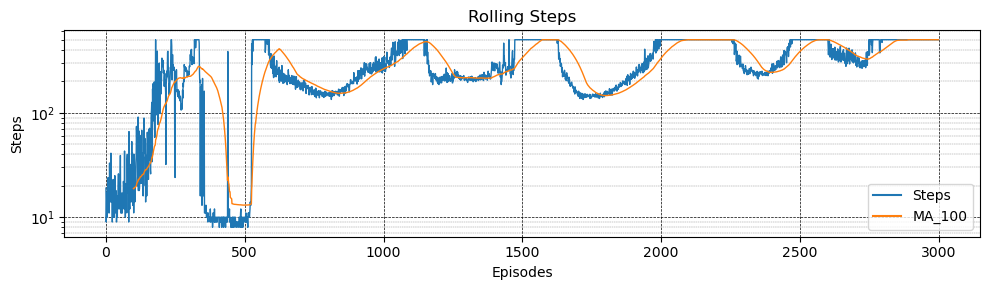

In [21]:
env = EnvCartPole(new_step_api=False)
agent4 = DQNAgent(env, n_episodes=3000, n_steps=1000, gamma=0.99, 
                  memory_cap=1000, batch_size=32, alpha=1.0e-4, tau=0.005,
                  epsilon=None, epsilon_start=0.95, epsilon_end=0.005, epsilon_decay=1.0e+04, 
                  checkpoint_name="policy4", )
agent4.run(new_r=False)
agent4.rolling_plot()

## 4.4. DQN Agent Comparison

Set epsilon to 0 to apply trained DQN Agent.

read checkpoint from ./policy3.json
Epsilon starts from 0.0000
read checkpoint from ./policy4.json
Epsilon starts from 0.0050


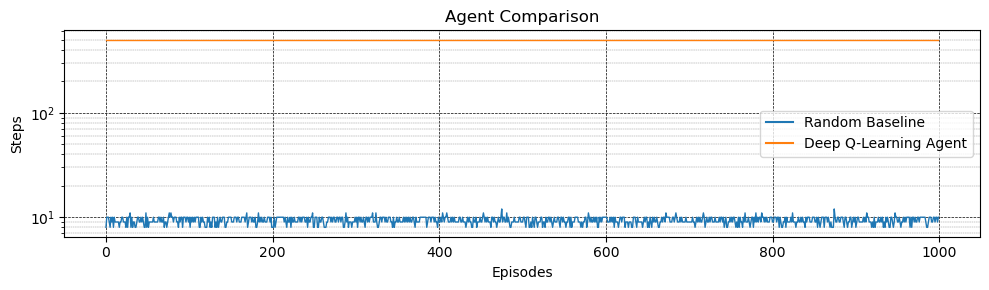

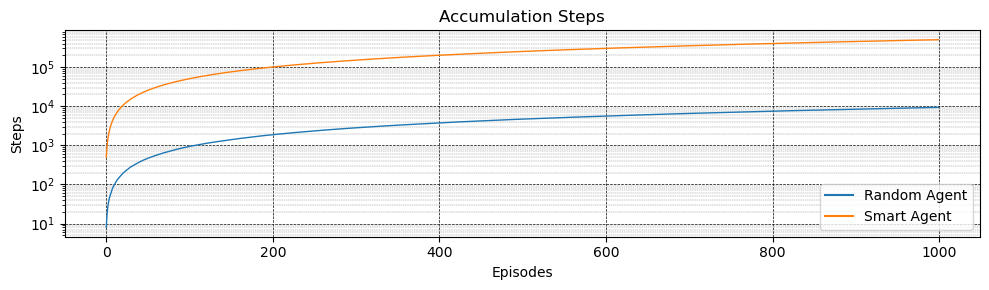

In [22]:
# define e=0 to apply policy 1, which is a random baseline
agent3.epsilon=0
agent3.n_episodes=1000
test3 = agent3.test(new_r=False)

# define e=0 to apply policy 1, which is a well traind DQN Agent
agent4.epsilon=0
agent4.n_episodes=1000
test4 = agent4.test(new_r=False)

# plot and compare them
df = pd.DataFrame({"Random Baseline": test3[-1000:], "Deep Q-Learning Agent": test4[-1000:]})
df = df.stack().reset_index()
df.columns = ["x", "hue", "y"]

agent4.vis(df, "Agent Comparison", "Episodes", "Steps", "Agent comparison")
agent4.cumsum_plot(test3, test4)

### Reload the weights and run it again with visualization

In [28]:
# !pip install pyvirtualdisplay
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(640, 640))
# display.start()

In [25]:
agent4.policy_net.save("policy4_500/policy_net/")
agent4.target_net.save("policy4_500/target_net/")

INFO:tensorflow:Assets written to: policy4_500/policy_net/assets
INFO:tensorflow:Assets written to: policy4_500/target_net/assets


In [ ]:
dnn = Sequential([
    Input(shape=(4,)),
    Dense(128, activation=relu),
    Dense(128, activation=relu),
    Dense(2, activation=linear)
])
dnn.compile(loss=mse, optimizer=Adam(learning_rate=1.0e-4))
dnn._name = "agent_best_ever"
dnn.load_weights("policy4_500/target_net/")

try:
    env = Env(new_step_api=True)
except Exception:
    env = Env()
for episode in range(1, 11):
    s = env.reset()
    for step in count():
        a = np.argmax(dnn(s))
        env.render()
        s, _, done, trunc = env.step(a)
        if done or trunc:
            print("[%d/%d]: steps %d" % (episode, 10, step + 1))
            break

i = 0

## 4.5. Keras-RL Library Implementation

In [14]:
!pip install keras-rl2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 KB 7.6 MB/s eta 0:00:00


In [21]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam
from keras import Sequential, Input

from rl.agents.dqn import DQNAgent as KerasDQN
from rl.policy import BoltzmannQPolicy, Policy, GreedyQPolicy
from rl.memory import SequentialMemory
from rl.agents.dqn import DQNAgent as KerasDQN

In [22]:
env = gym.make('CartPole-v1')

def get_model():
    keras_dqn = Sequential()
    keras_dqn.add(Dense(20, activation='relu', input_shape=(1, 4)))
    keras_dqn.add(Dense(20, activation='relu'))
    keras_dqn.add(Dense(2, activation='linear'))
    keras_dqn.add(Flatten())
    print(keras_dqn.summary())
    return keras_dqn

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [23]:
class RandomQPolicy(Policy):
    """Implement the random policy
    Random policy returns a random action
    """
    def select_action(self, q_values):
        assert q_values.ndim == 1
        action = np.random.randint(0, 1)
        return action

policy_random = RandomQPolicy()
policy_greedy = GreedyQPolicy()

In [25]:
def foo(policy):
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = KerasDQN(model=get_model(), nb_actions=2, memory=memory, nb_steps_warmup=10, target_model_update=1e-2, policy=policy)
    dqn.compile(Adam(lr=1e-3), metrics=['mse'])
    trains = dqn.fit(env, nb_steps=30, visualize=False, verbose=2)
    tests = dqn.test(env, nb_episodes=10, visualize=False)
    # dqn.save_weights('dqn_{}_weights.h5f'.format("CartPole-v1"), overwrite=True)
    return trains, tests

In [26]:
trains1, tests1 = foo(policy_random)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1, 20)             100       
                                                                 
 dense_13 (Dense)            (None, 1, 20)             420       
                                                                 
 dense_14 (Dense)            (None, 1, 2)              42        
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
Total params: 562
Trainable params: 562
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Training for 30 steps ...
 10/30: episode: 1, duration: 0.101s, episode steps:  10, steps per second:  99, episode reward: 10.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: --, mse: --, mean_q: --


/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
/usr/local/lib/python3.9/dist-packages/rl/memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')
/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 11 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)
/usr/local/lib/python3.9/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` 

 19/30: episode: 2, duration: 0.583s, episode steps:   9, steps per second:  15, episode reward:  9.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.420556, mse: 0.460927, mean_q: -0.190358
 27/30: episode: 3, duration: 0.091s, episode steps:   8, steps per second:  88, episode reward:  8.000, mean reward:  1.000 [ 1.000,  1.000], mean action: 0.000 [0.000, 0.000],  loss: 0.292390, mse: 0.318318, mean_q: -0.031257
done, took 0.816 seconds
Testing for 10 episodes ...
Episode 1: reward: 10.000, steps: 10
Episode 2: reward: 11.000, steps: 11
Episode 3: reward: 10.000, steps: 10
Episode 4: reward: 11.000, steps: 11
Episode 5: reward: 10.000, steps: 10
Episode 6: reward: 9.000, steps: 9
Episode 7: reward: 10.000, steps: 10
Episode 8: reward: 10.000, steps: 10
Episode 9: reward: 10.000, steps: 10
Episode 10: reward: 8.000, steps: 8


/usr/local/lib/python3.9/dist-packages/rl/memory.py:38: DeprecationWarning: This function is deprecated. Please call randint(1, 31 + 1) instead
  batch_idxs = np.random.random_integers(low, high - 1, size=size)


In [ ]:
trains2, tests2 = foo(policy_random)

In [ ]:
trains1.history

{'episode_reward': [304.0, 258.0, 194.0, 211.0],
 'nb_episode_steps': [304, 258, 194, 211],
 'nb_steps': [304, 562, 756, 967]}

In [ ]:
tests1.history

{'episode_reward': [240.0, 258.0, 264.0, 244.0, 250.0],
 'nb_steps': [240, 258, 264, 244, 250]}